This is the basic environment. stumpy is the main library we're working with, numpy and pandas are for all intents and purposes required to work with datasets and matplotlib allows us nice output.

In [1]:
import pandas
import stumpy
import numpy
import matplotlib.pyplot as plot
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

Basic utilities used to output the time it takes to compute a matrix profile over a given number of windows.

In [2]:
from functools import wraps
import time
def timeit(fn):
    def timed(*args, **kw):
        print (f'>>> {fn.__name__} >>>')

        ts = time.time()
        result = fn(*args, **kw)
        te = time.time()

        print (f'<<< {fn.__name__} <<< {(te-ts):.3f}s')
        return result
    return timed

@timeit
@wraps(stumpy.stump)
def timed_stump(dataset, w):
    l = len(dataset)
    ws = l - w + 1
    print(f'Processing a matrix profile over {ws} windows...')
    result = stumpy.stump(dataset, w)
    return result

More utilities to encapsulate the process of plotting our data.

In [3]:
from string import capwords
plot.style.use("data/stumpy.mplstyle")
def plot_pandas_import (plot_, data, axis_name):
    plot_.set_ylabel(capwords(axis_name), fontsize='15')
    plot_.plot(data[axis_name].values)

In [4]:
def plot_matrix_profile(plot_, profile):
    plot_.set_xlabel('Time', fontsize='15')
    plot_.set_ylabel('Distance', fontsize='15')
    plot_.plot(profile[:, 0])

Load the data!

In [5]:
steam_data = pandas.read_csv("data/STUMPY_Basics_steamgen.csv")

In [6]:
steam_data[:4]

drum pressure  excess oxygen  water level  steam flow
0      320.08239       2.506774     0.032701    9.302970
1      321.71099       2.545908     0.284799    9.662621
2      320.91331       2.360562     0.203652   10.990955
3      325.00252       0.027054     0.326187   12.430107

Automates the process of marking a motif or discord. Note that extracting a discord (or radically different sample) from a matrix profile is the same process as extracting a motif but with the matrix profile in reverse order allowing us to generalize into the threshold_extraction function. This function is also capable of marking every repeat in a motif group, rather than simply taking the first two values.

In [7]:
def threshold_extraction(op, cmp, profile, motif_order, window_width, threshold):
    assert(0 < threshold < 1.0)
    closest = profile[motif_order[0], 0]
    cutoff = op(closest, (closest * threshold))
    rv = []
    
    for obs in motif_order:
        if cmp(profile[obs,0], cutoff):
            if not (any(map(lambda i: abs(i - obs) < window_width, rv))):
                rv.append(obs)
            else:
                # If two motifs overlap it's possible the window is too small?
                # Further criteria needed for that...
                pass
        else:
            break
    return rv

def get_motifs(profile, motif_order, window_width, threshold):
    return threshold_extraction(lambda a, b: a + b
                               ,lambda a, b: a < b
                               ,profile
                               ,motif_order
                               ,window_width
                               ,threshold)

def get_discords(profile, motif_order, window_width, threshold):
    return threshold_extraction(lambda a, b: a - b
                               ,lambda a, b: a > b
                               ,profile
                               ,numpy.flip(motif_order)
                               ,window_width
                               ,threshold)

def mark_discovered(motif_list, data_fig, profile_fig, window_width, fig_height):
    for motif in motif_list:
        rect = Rectangle((motif, 0), window_width, fig_height, facecolor='lightgrey')
        data_fig.add_patch(rect)
        profile_fig.axvline(x=motif, linestyle='dashed')



Now we can actually do our calculations...

In [8]:
window = 640
matrix_profile = timed_stump(steam_data['steam flow'], window)
motif_order = numpy.argsort(matrix_profile[:,0])
motif_list = get_motifs(matrix_profile, motif_order, window, 0.01)
discord_list = get_discords(matrix_profile, motif_order, window, 0.005)

>>> stump >>>
Processing a matrix profile over 8961 windows...
<<< stump <<< 12.601s


... and report what we've discovered.

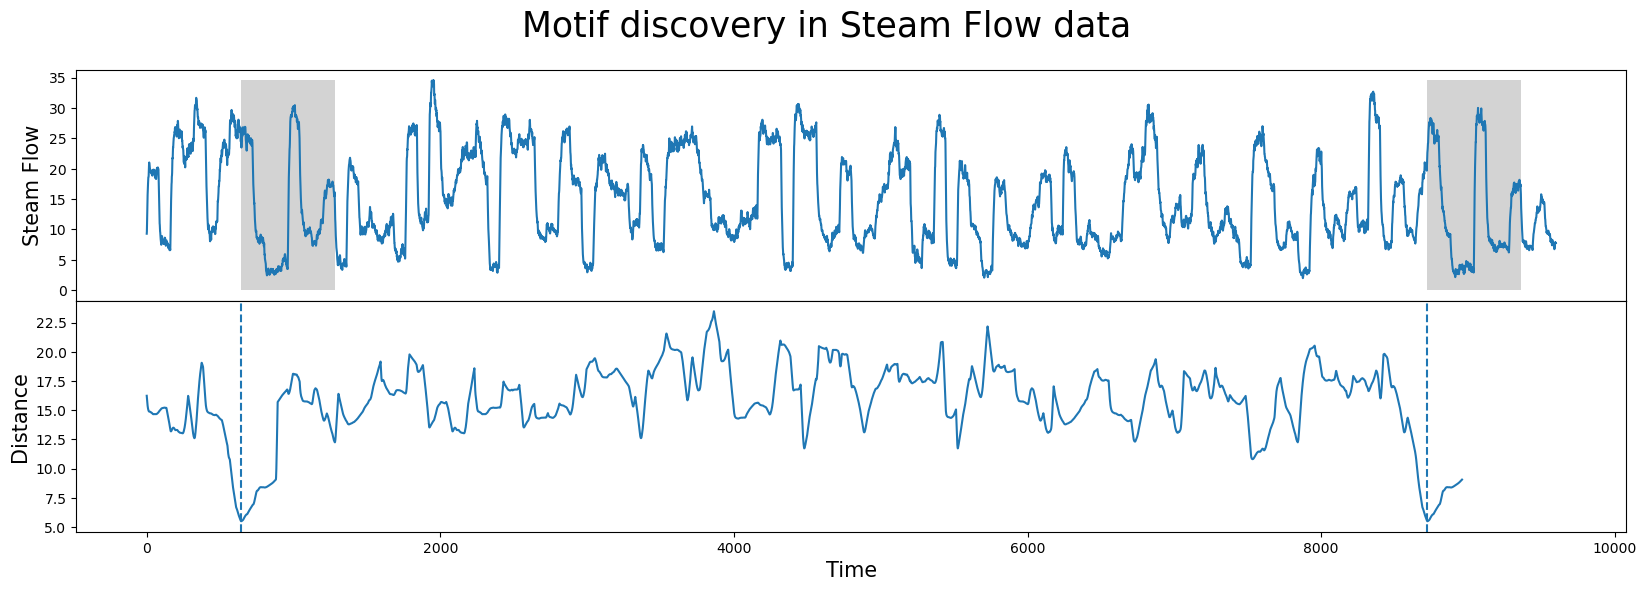

In [9]:
figure, axis = plot.subplots(2, sharex=True, gridspec_kw={'hspace':0})
plot.suptitle("Motif discovery in Steam Flow data", fontsize='25')
plot_pandas_import(axis[0], steam_data, 'steam flow')
plot_matrix_profile(axis[1], matrix_profile)
mark_discovered(motif_list, axis[0], axis[1], window, max(steam_data['steam flow']))

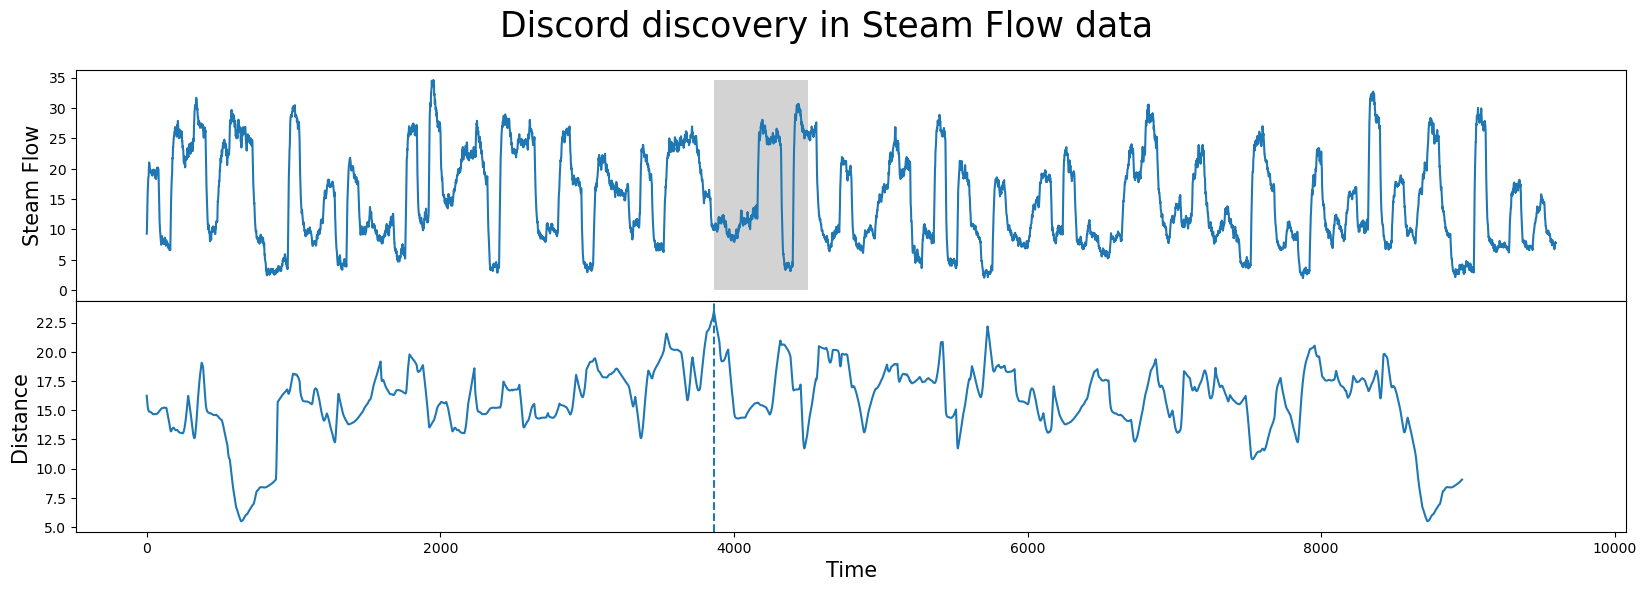

In [10]:
figure, axis = plot.subplots(2, sharex=True, gridspec_kw={'hspace':0})
plot.suptitle("Discord discovery in Steam Flow data", fontsize='25')
plot_pandas_import(axis[0], steam_data, 'steam flow')
plot_matrix_profile(axis[1], matrix_profile)
mark_discovered(discord_list, axis[0], axis[1], window, max(steam_data['steam flow']))

The graphs show our dataset on top and the distance profile on bottom. The distance profile plots a sliding window's closeness to its nearest neighbor. The low points are places where the data is most similar to some other sample and the high points represent radically different patterns which appear nowhere else in the data. The matrix profile is simply the distance profile sorted from lowest distance value to greatest.